In [417]:
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

# read data

In [418]:
words = open('../data/names.txt', 'r').read().splitlines()

In [419]:
len(words)

32033

In [420]:
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [421]:
chars = sorted(list(set(''.join(words))))

# util

In [422]:
itos = {}
itos[0] = '.'
itos |= {i+1: s for i, s in enumerate(chars)}

In [423]:
stoi = {s: i for i, s in itos.items()}

# Build a neural language model

## prepare data

In [424]:
block_size = 3
X, Y = [], []
for w in words[:]:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        # print(''.join([itos[i] for i in context]), '--->', itos[ix])
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]        

In [425]:
X = torch.tensor(X)
Y = torch.tensor(Y)        

In [426]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

## embedding matrix C

In [427]:
C = torch.randn(len(itos), 2)
C.shape

torch.Size([27, 2])

In [428]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

## hidden layer

In [429]:
w1 = torch.randn(6, 100)
b1 = torch.randn(100)

In [430]:
h = (emb.view(emb.shape[0], -1) @ w1 + b1).tanh()
h.shape

torch.Size([228146, 100])

## final layer

In [431]:
w2 = torch.randn(100, len(itos))
b2 = torch.randn(len(itos))

In [432]:
logits = h @ w2 + b2
logits.shape

torch.Size([228146, 27])

In [433]:
loss = F.cross_entropy(logits, Y)
loss

tensor(16.5412)

# Train a neural language model

In [434]:
C = torch.randn(len(itos), 2)
w1 = torch.randn(6, 100)
b1 = torch.randn(100)
w2 = torch.randn(100, len(itos))
b2 = torch.randn(len(itos))
parameters = [C, w1, b1, w2, b2]

In [435]:
sum(p.nelement() for p in parameters)

3481

In [436]:
for p in parameters:
    p.requires_grad = True

In [437]:
loglossi = []
lossi = []
for _ in tqdm(range(100_000)):
    # mini-batch
    ix = torch.randint(0, X.shape[0], (32,))
    Xb, Yb = X[ix], Y[ix]
    # forward
    emb = C[Xb] # (32, 3, 2)
    h = (emb.view(emb.shape[0], -1) @ w1 + b1).tanh() # (32, 100)
    logits = h @ w2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yb)

    # backward
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data += -0.1 * p.grad
        
    # tracking
    loglossi.append(loss.log10().item())
    lossi.append(loss.item())

100%|████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:31<00:00, 3144.67it/s]


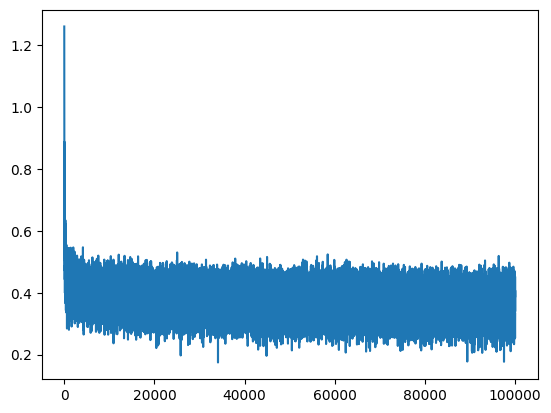

In [438]:
plt.plot(loglossi)

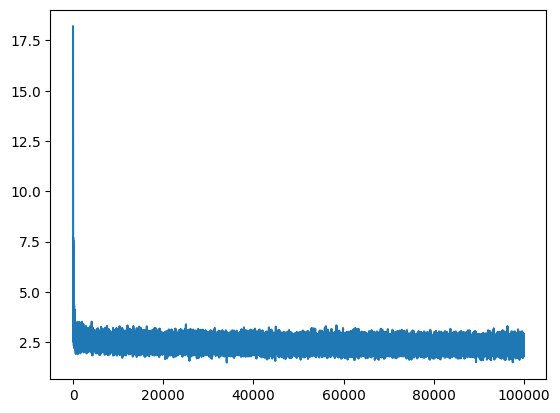

In [439]:
plt.plot(lossi)

In [440]:
lossi[-5:]

[2.5513439178466797,
 2.4700465202331543,
 2.388709783554077,
 2.3572518825531006,
 2.4467356204986572]

In [441]:
logits.shape

torch.Size([32, 27])

## compute loss on train

In [442]:
with torch.no_grad():
    emb = C[X] # (32, 3, 2)
    h = (emb.view(emb.shape[0], -1) @ w1 + b1).tanh() # (32, 100)
    logits = h @ w2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y)
    print(loss.item())

2.322096824645996
